<br>
<h1 style="color:#00acee; font-family:lato; font-size:300%; text-align:center;"> 
    Twitter
</h1>

***

In this project I want to do some analysis on tweets related to the [**#LoveIsNotTourism** movement](https://www.loveisnottourism.org/) ❤. 

All the dates are given with respect to the Universal Coordinated Time [**UTC**](https://en.wikipedia.org/wiki/Coordinated_Universal_Time) timezone

In [2]:
# !pip install GetOldTweets3 #If you need to install this package, uncomment this line and run it
import GetOldTweets3 as got 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re 
from datetime import timedelta
import datetime
import pytz
# WordCloud:
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Necessary to plot timeseries:
pd.plotting.register_matplotlib_converters()

The GetOldTweets3 package is really nice because it allows you to look for very old tweets (as opposed to the free version of the API from twitter). However, the downside is that it has less functionality.

Nonetheless, as we shall see, this package provides enough functionality to make a nice analysis about a specific topic.

GOT3 allows some criteria one can make use of to search on the Twit-sphere 
<img src='https://miro.medium.com/max/576/1*xVu-oaDRWW4yWF7yZ8W4Xw.png'>

# Own tweets 
To start trying out this package, first I would like to have a look at my latest tweets

## Search criteria
This is how to make a search on Twitter with GetOldTweets3

In [2]:
%%time
# First let's set some criteria search
username='@leopoldo_cus'
count=1000
interesting_text=''# '#LoveIsNotTourism'

# This is how to make a search on Twitter with GetOldTweets3
tweetCriteria = got.manager.TweetCriteria().setUsername(username).setMaxTweets(count).setQuerySearch(interesting_text).setEmoji("unicode")
# List of twits 
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

Wall time: 14.6 s


## Creating a dataframe

We have a list of twitter objects and would like now to create lists which will enable us to put a dataframe together. 

We will define a function that translates a list of tweet objects into a friendly, understandable pandas dataframe

In [71]:
%%time
def TweetDataframe(tweets):
    text = []
    usr = []
    rt=[]
    fav=[]
    ht=[]
    mentions=[]
    id_ = []
    date=[]
    # geo=[]
    for i in range(len(tweets)):
    #     print('{} \n '.format(got.manager.TweetManager.getTweets(tweetCriteria)[i].text ) )
        id_.append( tweets[i].id )
        text.append( tweets[i].text )
        usr.append(  tweets[i].username )
        rt.append( tweets[i].retweets )
        ht.append( tweets[i].hashtags )
        mentions.append( tweets[i].mentions )
        fav.append( tweets[i].favorites )
        date.append(tweets[i].date)
        #     geo.append( tweets[i].geo )

    # Create dataframe
    df = pd.DataFrame.from_dict({'date':date, 'usr':usr, 'ht':ht, 'mentions':mentions, 'rt':rt, 'fav':fav, 'text':text, 'ind':id_ } )
    df = df.set_index('ind')
    
    return df

df_leo = TweetDataframe(tweets)


Wall time: 3.99 ms


In [4]:
# Remove known ads
ads_usr = ['MovistarMX', 'danielchayau']
df_leo=df_leo[ ~df_leo.usr.isin(ads_usr) ]

# df_leo.head()

In [5]:
# Check out all the users:
df_leo.usr.unique()

array(['leopoldo_cus'], dtype=object)

### Plot

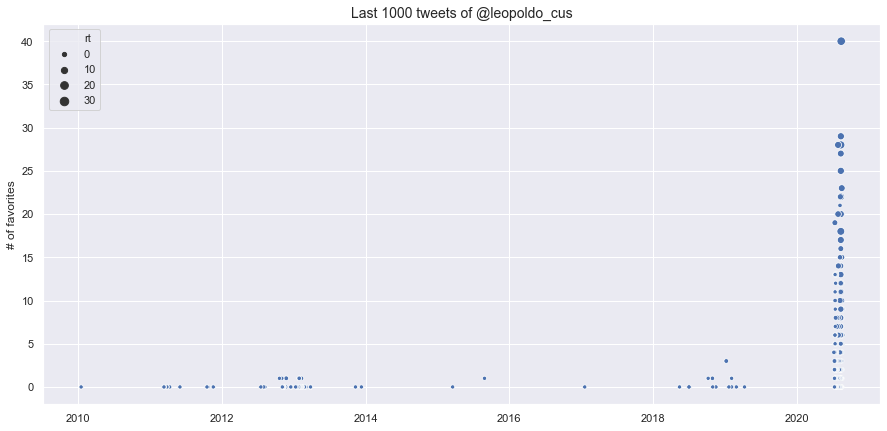

In [6]:
sns.set()
plt.figure(figsize=(15,7))
sns.scatterplot(x='date', y='fav', size='rt', data=df_leo)
plt.ylabel('# of favorites');
plt.xlabel('')
plt.title('Last {} tweets of {}'.format(count, username), size=14);
# sns.scatterplot(x='date', y='rt', data=df)

# #LoveIsNotTourism analysis
After importing several days of data from Twitter (mentioning this hashtag) with a given function that I will now show you, I have created a csv that I will later import and update

In [222]:
df.date.iloc[-1]

Timestamp('2020-08-22 00:04:59+0000', tz='UTC')

## Creation of database

In [261]:
# %%time

# # Create empty dataframe
# df = pd.DataFrame(columns = ['date', 'usr', 'ht', 'mentions', 'rt', 'fav', 'text', 'top_usr','ind'])
# df = df.set_index('ind')
# checkpoint=0


# # 🔥 Search Criteria. This is the place to change the topic, hashtag or so
# count= 7e4 #1e5
# interesting_text='#LoveIsNotTourism'# AND @robersperanza' 
# today = datetime.datetime.today()
# days = 30*8

# for i in range(checkpoint+1,days):
    
#     end_date = (today + timedelta(-i)).strftime('%Y-%m-%d') # End date to search
#     start_date = (today + timedelta(-i-1)).strftime('%Y-%m-%d')
    
#     # This is how to make a search on Twitter with GetOldTweets3
#     tweetCriteria = got.manager.TweetCriteria()\
#                     .setMaxTweets(count)\
#                     .setQuerySearch(interesting_text)\
#                     .setEmoji("unicode")\
#                     .setSince(start_date)\
#                     .setUntil(end_date)
#     #                 .setQuerySearch(mention)\
#     # List of twits 
#     tweets = got.manager.TweetManager.getTweets(tweetCriteria)
#     # Create DataFrame with previously defined function
#     current_df = TweetDataframe(tweets)
#     # Append current_df to df
#     df = pd.concat([df,current_df])
#     checkpoint = int(i)
# len(df)

Wall time: 20.4 s


135418

## Import database and update
Let's now import the aforementioned dataframe:

In [204]:
%%time
# En Windows, el path se tiene que escribir con "\\" en lugar del usual "/"
# df = pd.read_csv("C:\\Users\\cuspi\\Documents\\Databases\\Twitter\\twitter_lint_bulk.csv", parse_dates=['date']) #Usa este si quieres comenzar desde el update que llegó hasta el 17 de Agosto
df = pd.read_csv("C:\\Users\\cuspi\\Documents\\Databases\\Twitter\\twitter_lint.csv", parse_dates=['date'])
df = df.set_index('ind')

Wall time: 2.43 s


In [205]:
print('last update:', df.date.max().strftime('%Y-%b-%d'), '\nlen(df):    ',len(df))

last update: 2020-Aug-17 
len(df):     135418


Let's now update this database

In [206]:
count= 1e5 #1e5
interesting_text='#LoveIsNotTourism'# AND @robersperanza' 
today = datetime.datetime.today()

last_update = pd.to_datetime(df.date.max())

while (pd.to_datetime(today).replace(tzinfo=pytz.UTC) - last_update ).days > 0 :
    start_date = last_update.strftime('%Y-%m-%d')
    end_date = (last_update + timedelta(1) ).strftime('%Y-%m-%d')
    
    # This is how to make a search on Twitter with GetOldTweets3
    tweetCriteria = got.manager.TweetCriteria()\
                    .setMaxTweets(count)\
                    .setQuerySearch(interesting_text)\
                    .setEmoji("unicode")\
                    .setSince(start_date)\
                    .setUntil(end_date)
    #                 .setQuerySearch(mention)\
    # List of twits 
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    # Create DataFrame with previously defined function
    current_df = TweetDataframe(tweets)
    # Append current_df to df
    df = pd.concat([df,current_df])
    
    # Move on
    last_update = pd.to_datetime(df.date.max()+timedelta(1))
    # Check we're getting something
    print(len(df))

140226
142050
144375
146218
148025
149138


In [276]:
print('last update:', last_update.strftime('%Y-%b-%d'), '\nlen(df):    ',len(df))

last update: 2020-Aug-23 
len(df):     148025


## Remove ads

In [269]:
#This helps checking if there are ads:
df[df.index.duplicated()]

,date,usr,ht,mentions,rt,fav,text,top_usr
ind,,,,,,,,
1278840584678096897,2020-07-02 23:58:49+00:00,Weaverwerx,#LoveIsNotTourism #LiftTheTravelBan #LoveIsEssential,,1,3,Hopefully we will find out soon! #LoveIsNotTourism #LiftTheTravelBan #LoveIsEssential,NaN
1278840392549576706,2020-07-02 23:58:03+00:00,MichellSui,#VuelosInternacionalesYA #LoveIsEssential #LoveIsNotTourism,,0,0,"Dejen de hacer comerciales y trabajen para abrir el país, ustedes son complices de un secuestro masivo. Quiero, como muchos, volver a mi casa con mi familia. #VuelosInternacionalesYA #LoveIsEssential #LoveIsNotTourism",NaN
1278839748887547904,2020-07-02 23:55:30+00:00,LyraMarmos,#LiftTheTravelBan #LoveIsNotTourism,,0,0,#LiftTheTravelBan #LoveIsNotTourism I want to be with my wife again.,NaN
1278837956137168897,2020-07-02 23:48:23+00:00,bluejeanbaby728,#LoveIsNotTourism,,0,1,#LoveIsNotTourism,NaN
1278834716288966656,2020-07-02 23:35:30+00:00,LoveThruCOVID,#IWouldMarryYouIf #LoveIsNotTourism,,4,38,#IWouldMarryYouIf the government would make travel ban exemptions for separated couples! This seems like a Twitter trend a lot of #LoveIsNotTourism people can sadly relate to!,NaN
1278834142030028800,2020-07-02 23:33:13+00:00,juliabeate,#loveisessential #loveisnottourism,,0,5,"Norway: allows millions EU tourists without quarantine, students and work visas from all the world. Also Norway: still doesn't allow lovers and families to reunite, like Atle and his US wife of 5 years. #loveisessential #loveisnottourism",NaN
1278833535185498120,2020-07-02 23:30:49+00:00,Marieclnrck,#loveisessential #loveisnottourism #LiftTheTravelBan,@HeikoMaas,1,9,"The Federal Foreign Office is preaching about showing solidarity with Latin America. This is a slap in the face for Latin Americans who are separated from their german partners. @HeikoMaas Stop preaching, take action! #loveisessential #loveisnottourism #LiftTheTravelBan",NaN
1278833502834876416,2020-07-02 23:30:41+00:00,ExpatRak,#LoveIsNotTourism #LiftTheTravelBan #LiftThePhTravelBan #WeHealAsOne #ThisIsUs #loveisessential,,6,16,I said good bye about 5am on 3/2.I didn't think I would be sitting here 121 days later with no clue about when I will see them again. #LoveIsNotTourism #LiftTheTravelBan #LiftThePhTravelBan #WeHealAsOne #ThisIsUs #loveisessential https://twitter.com/weiselilien/status/1278395350093529088,NaN
1278833432475373568,2020-07-02 23:30:24+00:00,unholyhornbeam,#LoveIsNotTourism #LoveIsEssential,,11,45,I believe couples in long distance relationship shouldn't need to prove how committed they are... It takes so much commitment & strength to do what we do anyway. I believe we love more fiercely than most & have the strongest connections 🖤 #LoveIsNotTourism #LoveIsEssential,NaN


In [254]:
%%time 
# Remove known ads (this depends more on the IP address from where you run these queries and  )
ads_usr = ['MovistarMX', 'danielchayau','BUZZNET','hotelpricedrops', 'GamesRedDeer', 'sergistack', 'robersperanza', 'k_colonialism', 'VOANoticias','MasayukiTsuda2','POLITICOEurope']
df = df[ ~df.usr.isin(ads_usr) ]

Wall time: 59.8 ms


While importing tweets we might haave imported one of the more than once by calling the function on crossing dates. To ensure this is not a problem fron the follwoing analysis, we will remove these duplicates:

In [268]:
df = df.drop_duplicates(keep=False)

## Top usrs

In [277]:
%%time
# Select top users
top_number=20
top_users = df.sort_values(by=['fav','rt'], ascending=False).usr.unique()[:top_number].tolist()
df['top_usr'] = df['usr'].apply(lambda x: top_users.index(x)+1 if (x in top_users) else 0)

Wall time: 266 ms


## Time Series Plot
Let's take a look at the time behaviour of tweets discussing **#LoveIsNotTourism**

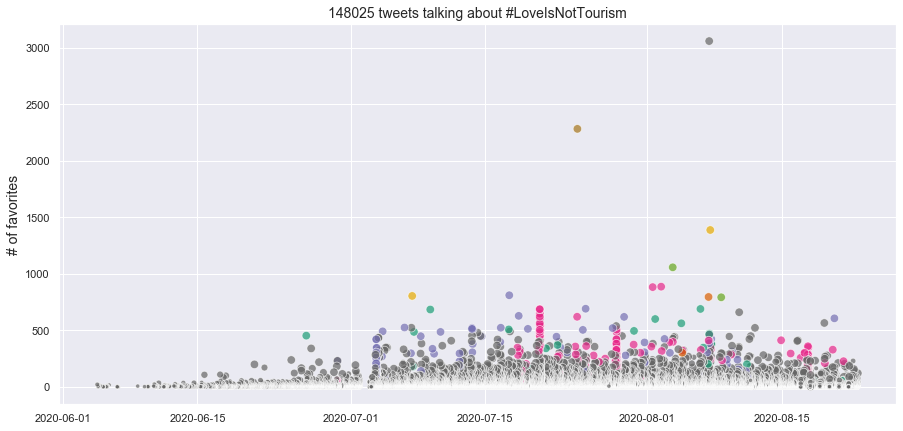

In [271]:
plt.figure(figsize=(15,7))

# sns.set()
# Colours
sns.set_palette("husl")


sns.scatterplot(x='date', y='fav', hue='top_usr', size=df.rt.astype('float'), size_norm=(5,50), data=df, 
                palette='Dark2_r', alpha=.7, legend=False)
plt.ylabel('# of favorites', size=14);
plt.xlabel('')
plt.title('{:.0f} tweets talking about {}'.format(len(df), interesting_text), 
          size=14);

# Tweets per day

In [272]:
df.resample('d', on='date').count().usr

date
2020-06-04 00:00:00+00:00       9
2020-06-05 00:00:00+00:00      12
2020-06-06 00:00:00+00:00       4
2020-06-07 00:00:00+00:00       0
2020-06-08 00:00:00+00:00       1
                             ... 
2020-08-18 00:00:00+00:00    1824
2020-08-19 00:00:00+00:00    2325
2020-08-20 00:00:00+00:00    1843
2020-08-21 00:00:00+00:00    1807
2020-08-22 00:00:00+00:00    1113
Freq: D, Name: usr, Length: 80, dtype: int64

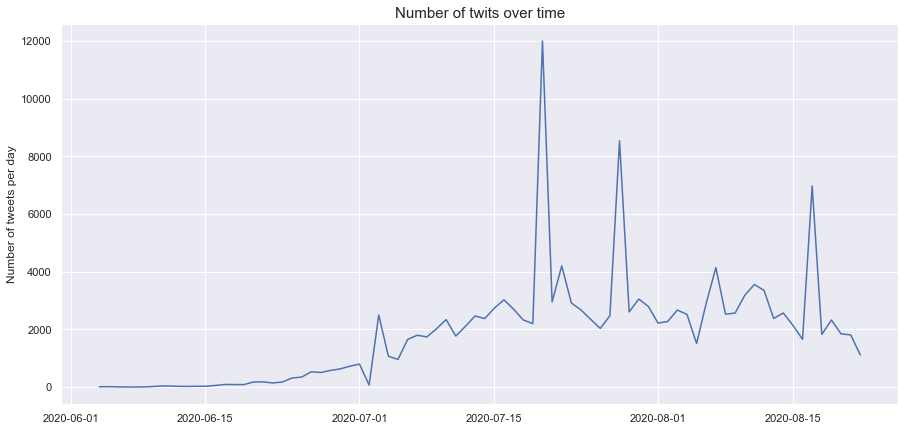

In [273]:
# df.resample('H', on='timestamps').mean()
sns.set()
plt.figure(figsize=(15,7))
plt.title('Number of twits over time', size=15)

# Plotting hist without kde
ax = sns.lineplot(x=df.resample('d', on='date').count().index, y=df.resample('d', on='date').count().usr);
ax.set_xlabel('');
ax.set_ylabel('Number of tweets per day');

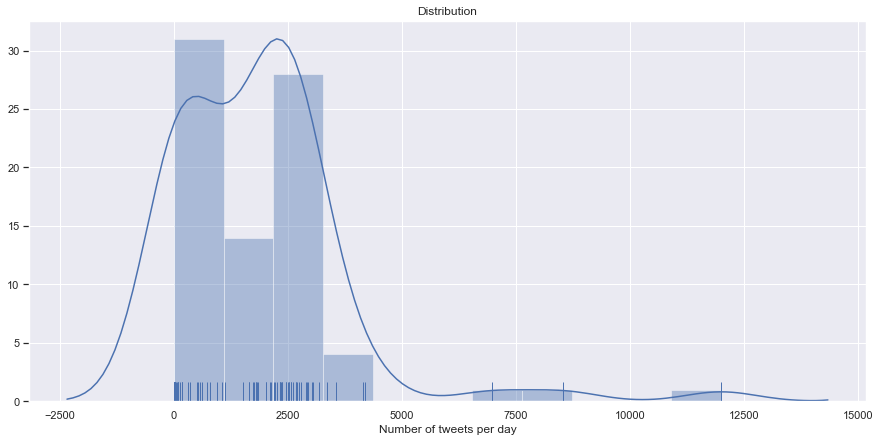

In [274]:
# df.resample('H', on='timestamps').mean()
plt.figure(figsize=(15,7))
plt.title('Distribution')

# Plotting hist without kde
ax = sns.distplot( df.resample('d', on='date').count().usr ,label='Count', kde=False);
# Creating another Y axis
second_ax = ax.twinx()

#Plotting kde without hist on the second Y axis
sns.distplot( df.resample('d', on='date').count().usr , ax=second_ax, rug=True, kde=True, hist=False);
#Removing Y ticks from the second axis
second_ax.set_yticks([]);
ax.set_xlabel('Days distribution');
ax.set_xlabel('Number of tweets per day');

## Most engaging Tweets

In [214]:
# df_love.columns
# len(df_love)
# df_love[df_love.date<'2020-05']
# df_love[df_love.fav>500]
pd.set_option('display.max_colwidth', None)
df[df.fav>50].sort_values(['fav','rt'], ascending=False).loc[:,['date','usr','rt','fav','text']]

,date,usr,rt,fav,text
ind,,,,,
1291685856454086660,2020-08-07 10:41:21+00:00,EU_Commission,1314,3058,We encourage all EU countries to allow the entry of unmarried partners of EU citizens and residents into the EU without a delay. #LoveIsNotTourism #LoveIsEssential
1286698162615451650,2020-07-24 16:22:02+00:00,WhoopiGoldberg,1107,2282,Let's ask the government to lift or modify the travel bans related to COVID-19 to reunite couples and families. Please sign and pass along. #LoveIsNotTourism #LoveIsEssential https://petitions.whitehouse.gov/petition/lift-travel-ban-us-reunite-couples-and-families
1291726327758946304,2020-08-07 13:22:10+00:00,YlvaJohansson,554,1388,I fully support a common European approach to allow entry of people into EU if they have duly attested relationships with EU citizens & residents. I encourage Member States to do so. Thanks to Minister Seehofer @EU2020DE for cooperation on this #LoveIsNotTourism #LoveIsEssential
1290306220599869441,2020-08-03 15:19:10+00:00,JBLemoyne,361,1058,La crise sanitaire a séparé des couples suite à la fermeture de frontières. Les équipes @francediplo &amp; @Interieur_Gouv travaillent ac le collectif #LoveIsNotTourism qui porte légitimement ce sujet douloureux. ➡️ une solution dédiée sera mise en place ds les tout prochains jours.
1289868320833970181,2020-08-02 10:19:06+00:00,LovesNotTourism,585,887,"We’ve been separated from our loved ones for almost half a year. The most essential thing in our lives has been taken away. Meanwhile, Europeans are enjoying summer break and freely traveling accross the union. This injustice must end now. RT #LoveIsEssential #LoveIsNotTourism"
...,...,...,...,...,...
1291705954044481538,2020-08-07 12:01:12+00:00,MoritzTaz,5,51,In early months of Trump administration they waited until 5pm Friday to make announcements to avoid the opposition until after the weekend. I hope #Seehofer @BMI_Bund is not playing the same game and that the German #LoveIsNotTourism solution is as clear as Denmark. 2pm already
1284498992274055168,2020-07-18 14:43:19+00:00,anked,5,51,"Hier war ich gern Erstunterzeichnerin! fraktionsübergreifender Aufrufs Abgeordneter an die Bundesregierung: Liebespaare verschied. Staatsangehörigkeit sollen mit negativem Corona Test nicht länger an Landesgrenzen abgewiesen werden. Denn: #LoveIsNotTourism, #loveisessential! ❤️"
1289566525003685890,2020-08-01 14:19:53+00:00,vivalasel,2,51,"Erst haben Sie geschmunzelt, 2 Wochen später ziehen Sie mit. Bitte lassen Sie diesen Worten nun auch Taten folgen, Herr Maas. Seehofer sucht seit Monaten eine Lösung. Vielleicht können Sie ihn ja unterstützen? #LoveIsNotTourism"


# Export dataframe 

In [278]:
%%time
# Save the dfs to disk so that we can make use of it in Tableau 
df.to_csv('C:\\Users\\cuspi\\Documents\\Databases\\Twitter\\twitter_lint.csv')

Wall time: 2.83 s


# Sentiment analysis

In [216]:
def CleanText(txt):
    txt = re.sub(r'https?:\/\/S+','',txt) # Remove hyperlinks
    # Remove some nonsense
    txt = re.sub(r'dans le','',txt)
    txt = re.sub(r'Sie uns','',txt)
    txt = re.sub(r'RT[\s]+','',txt)
    
    return txt
stopwords = set(STOPWORDS)
stopwords.update(['lo', 'di', 'Herr', 'ist','de','die','a','por','https','I', 'noch', 'much', 'uns', 'many', 'day', 'come', 'los', 'eine', 'wie', 'aut', 'les', 'sind','un', 'et','il','le','las','la', 'nos','will', 'dan', 'se', 'au', 'una', 'unas', 'le', 'aut', 'and', 'den', 'ein', 'al', 'des','_','il', 'e', 'en', 'que', 'non', 'da', 'Ich', 'la', 'mit', 'zu', 'es', 'con', 'von', 'und', 'auf', 'auch','sich', 'der', 'hasta', 'das', 'Sie', 'para', 'el', 'per', ''])

In [217]:
%%time
allwords = ' '.join(df.text.apply(CleanText).values.tolist())
# allwords
mask = np.array(Image.open('C://Users//cuspi//Pictures//heart.jpg'))

wcloud = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=150, collocations=False, mode='RGBA',mask=mask, stopwords=stopwords,
                  font_path='C://WINDOWS//FONTS//LATOWEB-LIGHT.TTF').generate(allwords)

Wall time: 8.77 s


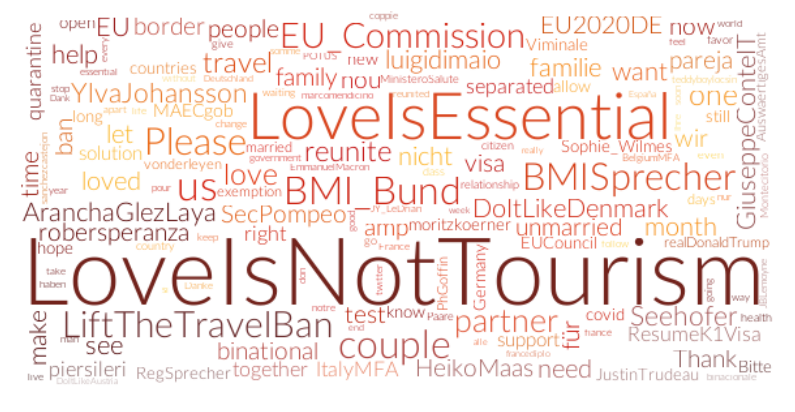

In [218]:
plt.figure(figsize=(14,8))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.imshow(wcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("C:/Users/cuspi/Documents/Databases/Twitter/lint.jpg", format="jpg")

## The beginning

In [273]:
df.sort_values(by='date').head(5)

,date,usr,ht,mentions,rt,fav,text,top_usr
ind,,,,,,,,
1268528745347940352,2020-06-04 13:03:15+00:00,28nine,#findasolution #reuniteinternationalcouples #lovewithoutborders #loveisnottourism,,9,22,Please find a solution for international couples. It's not tourism. We should have a possibility to be reunited even when we're not married. #findasolution #reuniteinternationalcouples #lovewithoutborders #loveisnottourism,0
1268561300629618689,2020-06-04 15:12:37+00:00,dniztasan,#reuniteinternationalcouples #loveisnottourism #LoveMatters,@BMI_Bund @tagesschau @HeikoMaas @Bundesregierung,2,8,We need an urgent solution to #reuniteinternationalcouples because #loveisnottourism &amp; #LoveMatters. @BMI_Bund @tagesschau @HeikoMaas @Bundesregierung,0
1268561659964149761,2020-06-04 15:14:03+00:00,dniztasan,#reuniteinternationalcouples #loveisnottourism,,0,2,#reuniteinternationalcouples #loveisnottourism,0
1268568152612495360,2020-06-04 15:39:51+00:00,wanjapfeil,#loveisnottourism #reuniteinternationalcouples,,0,10,Please find a solution for international couples! #loveisnottourism #reuniteinternationalcouples,0
1268570111155339264,2020-06-04 15:47:38+00:00,piasue1902,#internationalcouples #loveisnottourism #reuniteinternationalcouples,,3,19,Please finally come up with a solution for married and non-married #internationalcouples !! we are desperately waiting to see our partners from outside EU again ❤️🧡💛💚💙💜 #loveisnottourism #reuniteinternationalcouples,0


## Subjectivity and Polarity
LEt's define a couple of functions that will give us the subjectivity and the polarity of each tweet:

In [276]:
def GetSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def GetPolarity(txt):
    return TextBlob(txt).sentiment.polarity

# Create new columns:
df['subjectivity'] = df.text.apply(GetSubjectivity)
df['polarity'] = df.text.apply(GetPolarity)

In [277]:
df

,date,usr,ht,mentions,rt,fav,text,top_usr,subjectivity,polarity
ind,,,,,,,,,,
1295510539297333250,2020-08-17 23:59:16+00:00,AmandaR515,#LoveIsNotTourism,@Sethrogen,0,0,@Sethrogen Please help us out! #LoveIsNotTourism,0,0.000000,0.000000
1295510108265381889,2020-08-17 23:57:33+00:00,yarellycn,#LoveIsNotTourism,@francediplo,1,0,"Pourquoi rendre le processus un enfer? 3-5 semaines pour recevoir une réponse mais c'est pas tout, il faudra aussi attendre le visa. Est-ce que vous voulez vraiment qu'on se rencontre avec nos partenaires? @francediplo #LoveIsNotTourism",0,0.000000,0.000000
1295509988740419584,2020-08-17 23:57:05+00:00,LyssaLouis,#LoveIsNotTourism #ResumeK1Visa #LetUsMarry,@realDonaldTrump @StateDept @TravelGov @SecAzar @SecPompeo @DHSgov @DHS_Wolf,4,5,#LoveIsNotTourism #ResumeK1Visa #LetUsMarry @realDonaldTrump @StateDept @TravelGov @SecAzar @SecPompeo @DHSgov @DHS_Wolf,0,0.000000,0.000000
1295509692307865607,2020-08-17 23:55:54+00:00,JenzKSch,#ResumeK1Visa #LoveIsNotTourism,,3,10,"Intact tag from my return trip earlier this year, it was meant to be our last goodbye before we got married. We’ll be reunited finally this weekend and while I’m grateful we can reunite - I can’t help but feel sad we may have to say goodbye again #ResumeK1Visa #LoveIsNotTourism",0,0.563333,-0.050000
1295509412803743745,2020-08-17 23:54:48+00:00,tapho07,#visa_regroupement_algerien #LoveIsNotTourism,,1,0,"#visa_regroupement_algerien, 547 Nous sommes dans le désespoirs, nous réclamons notre droit au visa regroupement familial. 662 #LoveIsNotTourism",0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1268570111155339264,2020-06-04 15:47:38+00:00,piasue1902,#internationalcouples #loveisnottourism #reuniteinternationalcouples,,3,19,Please finally come up with a solution for married and non-married #internationalcouples !! we are desperately waiting to see our partners from outside EU again ❤️🧡💛💚💙💜 #loveisnottourism #reuniteinternationalcouples,0,0.575000,-0.052344
1268568152612495360,2020-06-04 15:39:51+00:00,wanjapfeil,#loveisnottourism #reuniteinternationalcouples,,0,10,Please find a solution for international couples! #loveisnottourism #reuniteinternationalcouples,0,0.000000,0.000000
1268561659964149761,2020-06-04 15:14:03+00:00,dniztasan,#reuniteinternationalcouples #loveisnottourism,,0,2,#reuniteinternationalcouples #loveisnottourism,0,0.000000,0.000000


# Tableau

This project gets much more interesting when one is able to interact with the data. 

In [this Tableau link](https://public.tableau.com/profile/leocuspinera#!/vizhome/Twitter_15978796836980/Dashboard?publish=yes) one can see why:

In [185]:
%%HTML
<iframe src='https://public.tableau.com/views/Twitter_15978796836980/Dashboard?:language=en-GB&:display_count=y&:showVizHome=no&publish=yes&:origin=viz_share_link'  width="100%" height="820 px" style="-webkit-transform:scale(0.8);-moz-transform-scale(0.8);" scrolling="yes" seamless="seamless" frameborder="0" allowfullscreen>

# Working station

In [60]:
%%time

# Create empty dataframe
df = pd.DataFrame(columns = ['date', 'usr', 'ht', 'mentions', 'rt', 'fav', 'text', 'top_usr','ind'])
df = df.set_index('ind')

# Let's set some criteria search
count= 1e3 #1e5
interesting_text='#LoveIsNotTourism'# AND @robersperanza' 
today = datetime.datetime.today()
days = 5

for i in range(days):
    
    end_date = (today + timedelta(-i)).strftime('%Y-%m-%d')
    start_date = (today + timedelta(-i-1)).strftime('%Y-%m-%d')
    
    # This is how to make a search on Twitter with GetOldTweets3
    tweetCriteria = got.manager.TweetCriteria()\
                    .setMaxTweets(count)\
                    .setQuerySearch(interesting_text)\
                    .setEmoji("unicode")\
                    .setSince(start_date)\
                    .setUntil(end_date)
    #                 .setQuerySearch(mention)\
    # List of twits 
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    # Create DataFrame with previously defined function
    current_df = TweetDataframe(tweets)
    # Append current_df to df
    df = pd.concat([df,current_df])
    
# Remove known ads
ads_usr = ['MovistarMX', 'danielchayau', 'GamesRedDeer', 'sergistack', 'robersperanza', 'k_colonialism']
df = df[ ~df.usr.isin(ads_usr) ]

df

Wall time: 3min 52s


,date,usr,ht,mentions,rt,fav,text,top_usr
ind,,,,,,,,
1295510539297333250,2020-08-17 23:59:16+00:00,AmandaR515,#LoveIsNotTourism,@Sethrogen,0,0,@Sethrogen Please help us out! #LoveIsNotTourism,NaN
1295510108265381889,2020-08-17 23:57:33+00:00,yarellycn,#LoveIsNotTourism,@francediplo,1,0,Pourquoi rendre le processus un enfer? 3-5 sem...,NaN
1295509988740419584,2020-08-17 23:57:05+00:00,LyssaLouis,#LoveIsNotTourism #ResumeK1Visa #LetUsMarry,@realDonaldTrump @StateDept @TravelGov @SecAza...,4,5,#LoveIsNotTourism #ResumeK1Visa #LetUsMarry @r...,NaN
1295509692307865607,2020-08-17 23:55:54+00:00,JenzKSch,#ResumeK1Visa #LoveIsNotTourism,,3,10,Intact tag from my return trip earlier this ye...,NaN
1295509412803743745,2020-08-17 23:54:48+00:00,tapho07,#visa_regroupement_algerien #LoveIsNotTourism,,1,0,"#visa_regroupement_algerien, 547 Nous sommes d...",NaN
...,...,...,...,...,...,...,...,...
1293929458005573632,2020-08-13 15:16:37+00:00,nildecreus98,#LoveIsNotTourism,,0,0,#LoveIsNotTourism,NaN
1293929417555632130,2020-08-13 15:16:27+00:00,hej0995,#LoveIsNotTourism #LiftTheTravelBanPH,@dododulay @teddyboylocsin @DFAPHL @immigrationPH,1,1,Yes please 😭🙏🏼🙏🏼🙏🏼 #LoveIsNotTourism #LiftTheT...,NaN
1293929316984795136,2020-08-13 15:16:03+00:00,Kaylee83545080,#LoveIsNotTourism #LoveIsEssential,@FacesofAdvocacy,1,8,Thank you Jack and the entire NDP for your sup...,NaN
